> source : https://github.com/ageron/handson-ml2/blob/master/13_loading_and_preprocessing_data.ipynb

In [255]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [256]:
x = tf.range(5)
dataset = tf.data.Dataset.from_tensor_slices(x)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [257]:
for item in dataset :
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


batch

In [258]:
dataset = dataset.batch(2)
for item in dataset :
    print(item)

tf.Tensor([0 1], shape=(2,), dtype=int32)
tf.Tensor([2 3], shape=(2,), dtype=int32)
tf.Tensor([4], shape=(1,), dtype=int32)


map function

In [259]:
dataset = dataset.map(lambda z : z*2)
for item in dataset :
    print(item)

tf.Tensor([0 2], shape=(2,), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor([8], shape=(1,), dtype=int32)


unbatch

In [260]:
dataset = dataset.unbatch()
for item in dataset :
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


In [261]:
dataset = dataset.filter(lambda x : x > 3) # keep only > 3
for item in dataset.take(2) : # get 2 sample
    print(item)

tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


In [262]:
dataset = tf.data.Dataset.range(20)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(6)
for item in dataset :
    print(item)

tf.Tensor([3 0 1 6 2 5], shape=(6,), dtype=int64)
tf.Tensor([ 7  8  4 11  9 14], shape=(6,), dtype=int64)
tf.Tensor([12 13 17 15 10 18], shape=(6,), dtype=int64)
tf.Tensor([19 16], shape=(2,), dtype=int64)


## Spliting the Data to CSV files

In [263]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

> For a very large dataset that does not fit in memory

In [264]:
def save_to_csv(data, name_prefix, header=None, n_parts=5) :
    data_dir = os.path.join('dataset', 'housing')
    os.makedirs(data_dir, exist_ok=True)
    path_format = os.path.join(data_dir, '_{}_{:02d}.csv')

    filepath = []
    m = len(data)
    for file_id, row_ in enumerate(np.array_split(np.arange(m), n_parts)) : # like batch
        part_csv = path_format.format(name_prefix, file_id)
        filepath.append(part_csv)

        with open(part_csv, 'wt', encoding='utf-8') as file : # write text mode
            if header : 
                file.write(header)
                file.write('\n')
            for row_id in row_ :
                file.write(','.join([ repr(column) for column in data[row_id] ]))
                file.write('\n')
    return filepath

In [265]:
# map x and y
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ['MedianHouseValue'] # x and y
header = ','.join(header_cols)

train_filepaths = save_to_csv(train_data, "train", header, n_parts=5)
valid_filepaths = save_to_csv(valid_data, "valid", header, n_parts=3)
test_filepaths = save_to_csv(test_data, "test", header, n_parts=3)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [266]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


## Building an Input Pipeline

In [267]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42) # shuffle  
for filepath in filepath_dataset :
    print(filepath)

tf.Tensor(b'dataset\\housing\\_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'dataset\\housing\\_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'dataset\\housing\\_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'dataset\\housing\\_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'dataset\\housing\\_train_02.csv', shape=(), dtype=string)


In [268]:
n_reader = 4
dataset = filepath_dataset.interleave( # like pipeline
    lambda filepath : tf.data.TextLineDataset(filepath).skip(1), # skip line 1
    cycle_length = n_reader)

<img src="https://i.stack.imgur.com/iSldR.png" width=600px />

> cycle_length = numpy of reader

In [269]:
for line in dataset.take(10) : # take 10 lines 
    print(line.numpy())

b'4.9803,29.0,5.33378196500673,1.0390309555854644,2104.0,2.831763122476447,33.83,-118.01,2.086'
b'3.5081,23.0,6.169603524229075,1.1167400881057268,1318.0,2.9030837004405288,40.52,-122.33,1.167'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'
b'4.163,49.0,4.71830985915493,0.9894366197183099,660.0,2.323943661971831,37.54,-122.31,3.938'
b'4.0729,4.0,6.163329161451815,1.1138923654568211,4546.0,2.8448060075093866,34.58,-118.03,1.543'
b'4.4896,48.0,4.989304812834225,1.0623885918003566,1235.0,2.201426024955437,34.07,-118.38,5.00001'
b'5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687'
b'4.5293,19.0,6.920661157024793,1.1305785123966943,1827.0,3.0198347107438015,38.34,-122.31,2.104'
b'4.45,31.0,5.154377880184332,0.9930875576036866,1135.0,2.6152073732718892,33.94,-117.95,2.679'
b'4.7411,35.0,4.759643916913946,0.9910979228486647,904.0,2.6824925816023737,34.36,-119.7,3.364'


In [270]:
record = [0, np.nan, tf.constant(np.nan, dtype=tf.float64), 'hello', tf.constant([])]
parsed_fileds = tf.io.decode_csv('1,,,,5', record) # for missing value
parsed_fileds

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Preprocess

In [271]:
n_inputs = 8 # x

@tf.function
def preprocess(line) :
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)] # for missing value , and last one for y_missing
    fileds = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fileds[:-1]) # don't want y
    y = tf.stack(fileds[-1])
    return (x - X_mean) / X_std, y # return scaler and y

In [272]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.782>)

> b' =  used to specify a bytes string

In [273]:
a = tf.constant([12,4,5])
b = tf.constant([1,4,1])
print(tf.stack([a,b]).numpy())

[[12  4  5]
 [ 1  4  1]]


In [274]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip header column
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

> dataset.prefetch(1) at the end of the pipeline (after batching). This will always prefetch one batch of data and make sure that there is always one ready.

In [275]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=5)
for x_batch, y_batch in train_set.take(2) :
    print('x :', x_batch.numpy())
    print('y :', y_batch.numpy())
    print('-----------\n')

x : [[ 2.2740278   0.6625668  -0.14016265 -0.32218233 -0.5277444  -0.4690744
  -0.7197856   0.6268896 ]
 [-0.4166814   0.5834586  -0.27819967 -0.36343482 -0.23388447 -0.24151908
   1.6413497  -1.0173439 ]
 [-0.63540334 -0.60316414 -0.1755314  -0.02318518 -0.04132406 -0.04645293
  -0.6260894   0.24207076]
 [-0.29249796  0.02970133 -0.5297631  -0.32667488 -0.67558706 -0.08503588
  -0.83690536  0.7518313 ]
 [-0.8063061   0.6625668  -0.64895284 -0.04169097 -0.30780578 -0.5935341
  -0.87906855  0.70185536]]
y : [4.302 0.74  1.84  1.988 3.25 ]
-----------

x : [[ 1.5568445e+00 -6.0316414e-01  7.2914946e-01 -3.1375077e-01
  -9.6993186e-02  4.1983075e-02  1.0744886e+00 -1.1822641e+00]
 [-9.3845069e-01 -9.1959685e-01 -4.3922710e-01 -2.8386047e-01
  -7.9331356e-01 -4.0453303e-01  1.8100007e+00 -1.3172033e+00]
 [-9.6353871e-01 -2.0762321e-01 -2.2058074e-01 -1.8000378e-01
   9.3242931e-01  2.3953319e-01  9.0115184e-01 -6.6250986e-01]
 [ 6.6922909e-01 -2.1062195e+00  7.2275180e-01  4.4363844e-01
  

In [276]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [277]:
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([ 
    tf.keras.layers.Input(shape=(8,)),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), metrics=['mse'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='save_model/checkponit_1')
model.fit(train_set.repeat(), steps_per_epoch=len(X_train), epochs=20,
          validation_data=valid_set, callbacks=[checkpoint])

Epoch 1/20
11610/11610 [==============================] - 11s 889us/step - loss: 0.5023 - mse: 0.5023 - val_loss: 0.3738 - val_mse: 0.3738
Epoch 2/20
11610/11610 [==============================] - 10s 874us/step - loss: 0.3828 - mse: 0.3828 - val_loss: 0.3504 - val_mse: 0.3504
Epoch 3/20
11610/11610 [==============================] - 10s 827us/step - loss: 0.3655 - mse: 0.3655 - val_loss: 0.4131 - val_mse: 0.4131
Epoch 4/20
11610/11610 [==============================] - 11s 918us/step - loss: 0.3566 - mse: 0.3566 - val_loss: 0.3366 - val_mse: 0.3366
Epoch 5/20
11610/11610 [==============================] - 11s 937us/step - loss: 0.3505 - mse: 0.3505 - val_loss: 0.3530 - val_mse: 0.3530
Epoch 6/20
11610/11610 [==============================] - 11s 934us/step - loss: 0.3455 - mse: 0.3455 - val_loss: 0.3755 - val_mse: 0.3755
Epoch 7/20
11610/11610 [==============================] - 11s 954us/step - loss: 0.3426 - mse: 0.3426 - val_loss: 0.4807 - val_mse: 0.4807
Epoch 8/20
11610/11610 [===

In [278]:
model.evaluate(test_set)

162/162 [==============================] - 0s 823us/step - loss: 0.3234 - mse: 0.3234


[0.323374480009079, 0.323374480009079]

In [287]:
model = tf.keras.models.load_model('save_model/checkponit_1')
model.evaluate(test_set)

162/162 [==============================] - 0s 817us/step - loss: 0.3207 - mse: 0.3207


[0.32069313526153564, 0.32069313526153564]

predictions

In [288]:
X_test, y_test = [], []
for x_test, y_test_ in test_set.unbatch() :
    X_test.append(x_test)
    y_test.append(y_test_)
X_test = np.array(X_test).reshape(-1,8)
y_test = np.array(y_test).reshape(-1,1)

In [289]:
y_pred = model.predict(X_test)
y_pred.shape

(5160, 1)

In [290]:
model.evaluate(X_test,y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3207 - mse: 0.3207


[0.3206932544708252, 0.3206932544708252]

In [291]:
mse = np.mean(np.square(y_pred-y_test))
mse

0.3206932

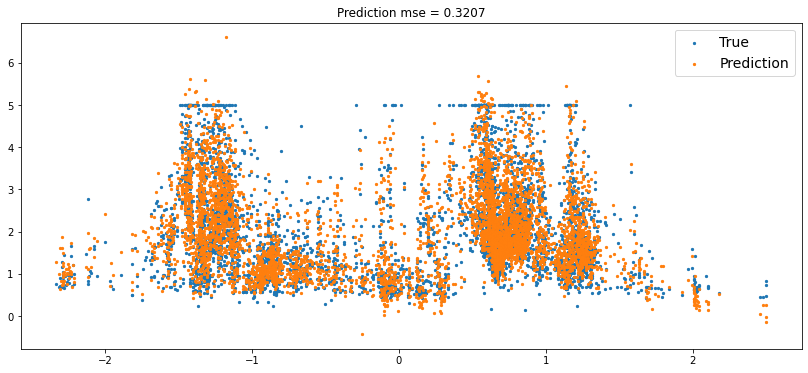

In [300]:
f = 7
plt.figure(figsize=(14,6))
plt.scatter(X_test[:,f], y_test, s=5, label='True')
plt.scatter(X_test[:,f], y_pred, s=5, label='Prediction')
plt.title(f'Prediction mse = {mse:.4f}')
plt.legend(fontsize=14);

## The TFRecord binary format

In [307]:
with tf.io.TFRecordWriter('data_record/data.tfrecord') as f :
    f.write('testing record')
    f.write('Scaler = 103.12')

In [329]:
file_path = ['data_record/data.tfrecord']
datarec = tf.data.TFRecordDataset(file_path)
for item in datarec.as_numpy_iterator():
    if str(item).startswith("b'Scaler") :
        std = float(str(item).split('=')[-1].strip("'")) # just get the number
        print(std)
    else :
        print(item)

b'testing record'
103.12
